<font size="6">Lending Club Analysis</font>

Objective:
- Tasked by an Investment firm to analyze the possibility of investing in Lending Club loans as part of our portfolio. 


Tasks:
-	Perform EDA to understand dataset.
-	Impute missing data.
-	Select features, removing ones that could lead to data leakage or are unimportant.
-	Train models to predict loan defaults.
-	Calculate the best CAGR.
-	Compare with other investment assets.
-	Conclusions.
-	Future work.

## Load Packages and Data

In [1]:
import numpy as np 
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import seaborn as sns
import plotly.graph_objects as go

plt.style.use("default")
sns.set_style('whitegrid')
%matplotlib inline

pd.set_option('display.float', '{:.2f}'.format)
pd.set_option('display.max_columns', 151)
pd.set_option('display.max_rows', 50)

In [2]:
data = pd.read_csv("G:\\Lending Club Data Files\\accepted_2007_to_2018Q4.csv")
#data = pd.read_csv("data\accepted_2007_to_2018Q4.csv")

C:\Users\Daniel\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [23]:
data.sample(1)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
1088231,70141197,NaN,7575.00,7575.00,7575.00,36 months,16.59,268.53,D,D2,truck driver,1 year,RENT,65000.00,Verified,2016-02-01,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,credit_card,Credit card refinancing,386xx,MS,16.27,1.00,Apr-2007,660.00,664.00,2.00,14.00,NaN,7.00,0.00,8349.00,76.60,10.00,w,0.00,0.00,8742.67,8742.67,7575.00,1167.67,0.00,0.00,0.00,Feb-2017,5789.14,NaN,Nov-2017,604.00,600.00,0.00,78.00,1.00,Individual,NaN,NaN,NaN,0.00,69.00,27685.00,1.00,1.00,1.00,1.00,4.00,19336.00,74.00,2.00,5.00,1023.00,75.00,10900.00,2.00,3.00,4.00,6.00,3955.00,891.00,57.60,0.00,0.00,35.00,105.00,8.00,4.00,0.00,18.00,14.00,5.00,14.00,1.00,2.00,3.00,3.00,5.00,2.00,5.00,8.00,3.00,7.00,0.00,0.00,0.00,3.00,80.00,33.30,0.00,0.00,37107.00,27685.00,2100.00,26207.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


## Understanding the Data

In [4]:
data.shape

(2260701, 151)

### Exploring Value of Loans Issued

In [5]:
loans_issued = data.groupby('issue_d')['loan_amnt'].sum().reset_index()
loans_issued['issue_d'] = pd.DatetimeIndex(loans_issued['issue_d']).year
loans_issued = loans_issued.groupby('issue_d').sum().reset_index()

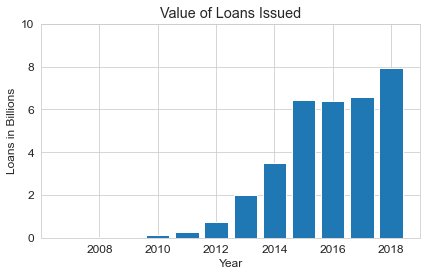

In [6]:
plt.rcParams.update({'font.size': 12})
f, ax = plt.subplots()
ax.bar(loans_issued.issue_d, loans_issued.loan_amnt)
# ax.tick_params(axis='y')
ax.set_ylabel('Loans in Billions')
ax.set(xlabel="Year",
      title="Value of Loans Issued")
f.tight_layout()  # otherwise the right y-label is slightly clipped
plt.yticks(ax.get_yticks(), (ax.get_yticks() / 1000000000).astype(int))
# plt.xticks(loans_issued.issue_d)
plt.show()
f.savefig('./images/value_of_loans.png', facecolor=f.get_facecolor(), transparent=True, dpi=500)

### Exploring the Target Variable

In [7]:
loan_status = data['loan_status'].value_counts().reset_index()
loan_status.columns = ['loan_status', 'count']
loan_status = loan_status[loan_status['loan_status'].isin(['Fully Paid', 'Charged Off'])]

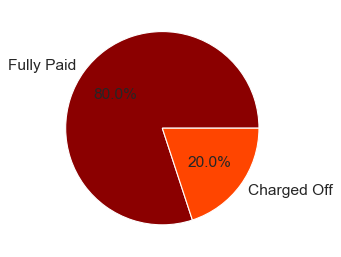

In [8]:
plt.rcParams['figure.dpi'] = 80
plt.rcParams.update({'font.size': 14})
f, ax = plt.subplots()
types = ['Fully Paid', 'Charged Off']
ax.pie(x=loan_status['count'], labels = types, autopct='%1.1f%%', colors=('darkred','orangered'))
plt.show()
f.savefig('./images/pie_loan_status.png', facecolor=f.get_facecolor(), transparent=True, dpi=500)

As expected we are dealing with an imbalanced dataset since one class represents only 20% of observations. In this case the null model, always guessing the fully paid class, would have an 80% accuracy. We have to work to improve on this null model. Using metrics other than accuracy such as specificity, sensitivity, F1, and area under the curve (AUC) we should get a better diagnostic of how well our model is working. In any case, our final performance metric should be one that measures the profit generated by the investor.

We might also want to do under-sampling or over-sampling, which either reduces the number of samples of the over represented observations or increases the under represented class. Furthermore, some algorithms on scikit learn can also account for unbalanced models.

### Exploring Loan Amount and Income

In [9]:
data['issue_d'] = pd.to_datetime(data['issue_d'])

In [10]:
loan_percent_income = data.groupby(pd.Grouper(key='issue_d',freq='Y'))[['loan_amnt', 'annual_inc']].mean().reset_index()
loan_percent_income['percent'] = loan_percent_income['loan_amnt']/loan_percent_income['annual_inc']
loan_percent_income['issue_d'] = pd.DatetimeIndex(loan_percent_income['issue_d']).year

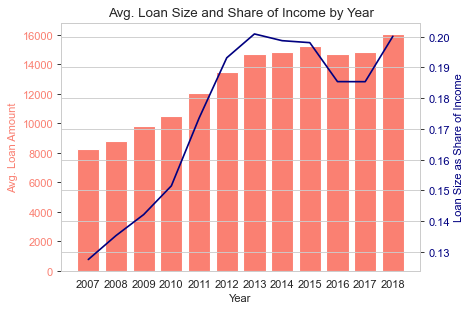

In [11]:
plt.rcParams.update({'font.size': 10})
f, ax = plt.subplots()
ax.grid(False)
color = 'salmon'
ax.bar(loan_percent_income.issue_d, loan_percent_income.loan_amnt, color=color)
ax.tick_params(axis='y', labelcolor=color)
ax.set_ylabel('Avg. Loan Amount', color=color)
ax.set(xlabel="Year",
      title="Avg. Loan Size and Share of Income by Year")

ax2 = ax.twinx()

color = 'navy'
ax2.set_ylabel('Loan Size as Share of Income', color=color)  # we already handled the x-label with ax1
ax2.plot(loan_percent_income.issue_d, loan_percent_income.percent, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.xticks(loan_percent_income.issue_d)

f.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
f.savefig('./images/avg_loan_byyear.png', facecolor=f.get_facecolor(), transparent=True, dpi=500)

### Exploring Loan Purpose

In [12]:
purpose = data.groupby([pd.Grouper(key='issue_d',freq='Y'), 'purpose']).size().reset_index()
purpose.columns = ['issue_d','purpose','count']
purpose['issue_d'] = pd.DatetimeIndex(purpose['issue_d']).year
purpose = purpose.pivot(index='issue_d', columns='purpose', values='count')
purpose = purpose.reset_index()
purpose['sum'] = purpose.iloc[:,1:].sum(axis=1)
purpose = purpose.fillna(0)
purpose.iloc[:, 1:-1]=purpose.iloc[:, 1:-1].div(purpose['sum'], axis=0)
purpose.drop('sum', axis=1, inplace=True)
purpose.sort_values(by=11, axis=1, ascending=False, inplace=True)

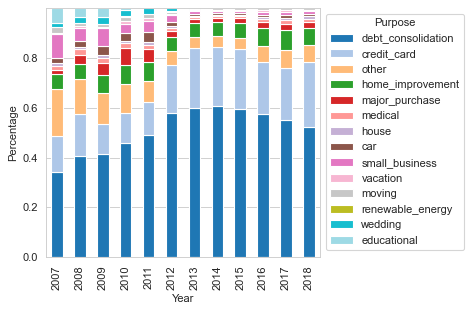

In [13]:
ax = purpose.plot(x='issue_d', kind='bar', stacked=True, colormap='tab20')
ax.set_ylabel('Percentage')
ax.set_xlabel('Year')
plt.legend(title='Purpose', bbox_to_anchor=(1.0, 1), loc='upper left')
plt.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig('./images/purpose.png', dpi=500)
plt.show()

### Exploring Location of Borrowers

In [38]:
states = data.groupby(['addr_state','issue_d'])['loan_amnt'].sum().reset_index()
states['issue_d'] = pd.DatetimeIndex(states['issue_d']).year
states = states.groupby(['addr_state','issue_d'])['loan_amnt'].sum().reset_index()
states['loan_amnt'] = round(states['loan_amnt']/1000000)
states = states[states['issue_d']==2018]

In [39]:
fig = go.Figure(data=go.Choropleth(
    locations=states['addr_state'], # Spatial coordinates
    z = states['loan_amnt'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Millions USD",
))

fig.update_layout(
    title_text = '2018 Loans Allocated by State',
    geo_scope='usa', # limite map scope to USA
)

fig.show()
fig.write_image("./images/loans_by_state.png", scale=2)

### Exploring Interest Rates

In [64]:
int_rate = data[['issue_d','int_rate']].copy()
int_rate['issue_d'] = pd.DatetimeIndex(int_rate['issue_d']).year
int_rate.dropna(inplace=True)
int_rate['issue_d'] = int_rate['issue_d'].astype(int)

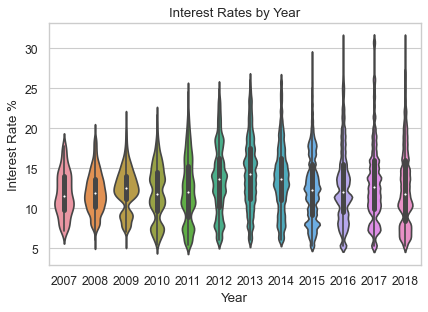

In [85]:
plt.subplots(dpi = 80)
sns.set_theme(style="whitegrid", font_scale=1.0)
g = sns.violinplot(data=int_rate, x="issue_d", y="int_rate", size="size")
g.set_title('Interest Rates by Year')
g.set_ylabel('Interest Rate %')
g.set_xlabel('Year')
plt.savefig('./images/int_rates.png', dpi=500)

## Preparing the Data for the Models

### Selecting Features

In [24]:
for e, column in enumerate(data.columns):
    print (e, column)

0 id
1 member_id
2 loan_amnt
3 funded_amnt
4 funded_amnt_inv
5 term
6 int_rate
7 installment
8 grade
9 sub_grade
10 emp_title
11 emp_length
12 home_ownership
13 annual_inc
14 verification_status
15 issue_d
16 loan_status
17 pymnt_plan
18 url
19 desc
20 purpose
21 title
22 zip_code
23 addr_state
24 dti
25 delinq_2yrs
26 earliest_cr_line
27 fico_range_low
28 fico_range_high
29 inq_last_6mths
30 mths_since_last_delinq
31 mths_since_last_record
32 open_acc
33 pub_rec
34 revol_bal
35 revol_util
36 total_acc
37 initial_list_status
38 out_prncp
39 out_prncp_inv
40 total_pymnt
41 total_pymnt_inv
42 total_rec_prncp
43 total_rec_int
44 total_rec_late_fee
45 recoveries
46 collection_recovery_fee
47 last_pymnt_d
48 last_pymnt_amnt
49 next_pymnt_d
50 last_credit_pull_d
51 last_fico_range_high
52 last_fico_range_low
53 collections_12_mths_ex_med
54 mths_since_last_major_derog
55 policy_code
56 application_type
57 annual_inc_joint
58 dti_joint
59 verification_status_joint
60 acc_now_delinq
61 tot_col

Using the dictionary with the descriptions I will review the features available to determine which were obtained after the loan origination to avoid data leakage. We should only use information available at loan origination in order to avoid having a model that overestimates its predictive power. The following are features I found to be available at origination and that are relevant:

- id, loan_amnt, term, int_rate, grade, sub_grade, emp_title, home_ownership, annual_inc, verification_status, issue_d, loan_status (target), purpose, zip_code, addr_state, dti, earliest_cr_line, fico_range_low, fico_range_high, open_acc, pub_rec, initial_list_status, application_type, annual_inc_joint, dti_joint, verification_status_joint, pub_rec_bankruptcies

Column index: 0, 2, 5, 6, 8, 9, 11, 12, 13, 14, 15, 16, 20, 22, 23, 24, 26, 27, 28, 32, 33, 37, 56, 57, 58, 59, 109

In [25]:
df = data.iloc[:,[0,2,5,6,8,9,11,12,13,14,15,16,20,22,23,24,26,27,28,32,33,37,56,57,58,59,109]]

### Filtering Rows that can be Used to Train our Model

Our analysis should only include observations where the target variable, loan_status, has a definite status in order to have a target that can be used to train our models. In this case, either the loan_status is "Fully Paid" or "Charged Off", which means it defaulted.

In [26]:
data.loan_status.value_counts()

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: loan_status, dtype: int64

In [27]:
df = df[df['loan_status'].isin(['Fully Paid', 'Charged Off'])]

###  Understanding Missing Data

In [90]:
nullseries = df.isnull().sum()
nullseries[nullseries > 0].sort_values(ascending=False)

verification_status_joint    1319715
dti_joint                    1319513
annual_inc_joint             1319510
emp_length                     78511
pub_rec_bankruptcies             697
dti                              374
zip_code                           1
dtype: int64

It seems most of the missing values for the joint data are missing because they do not apply since not all loan applicants do so with another person. 

In [ ]:
employment = df.